In [2]:
import gym
import numpy as np
import collections
import sys
from tqdm import tqdm
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import math
from Foraging_v0.envs.Foraging_env import ForagingEnv
from sklearn.neighbors import NearestNeighbors
import random
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical


/home/blank/anaconda3/envs/ml_rl/lib/python3.7/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [3]:
from torch.utils.tensorboard import SummaryWriter

In [4]:

RATE = 10
N =2000

/home/blank/ML project/foraging-v0-master-20220322T100127Z-001/foraging-v0-master/Foraging_v0/envs/Foraging_env.py:77: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.ax = mplot3d.Axes3D(self.fig)


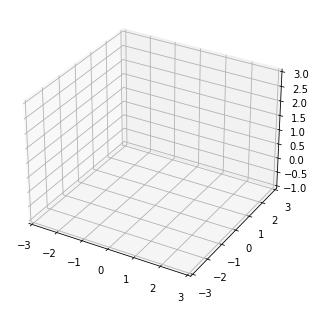

In [83]:
num_agents = 1
ep_len = 2000

init_pos = np.array([[1, 1, 1], # agent
                      [1, 1.3, 0.], #obst
                      [1.3, 1, 0.],
                      [0.9, 1, 0.],
                      [2, 2, 0.], 
                      [1.5, -2, 1]], dtype=np.float64) #target

env = ForagingEnv(num_agents=1,init_pos=init_pos, target=init_pos[-1])

In [6]:
env.action_space


[Box(-5.0, 5.0, (3,), float64)]

In [7]:
action = np.array([1, 1, 1], dtype=np.float64)
env.step(action)

(array([[ 1.1,  1.1,  1.1],
        [ 1. ,  1.3,  0. ],
        [ 1.3,  1. ,  0. ],
        [ 0.9,  1. ,  0. ],
        [ 2. ,  2. ,  0. ],
        [ 1.5, -2. ,  1. ]]),
 [-0.00055],
 False)

### Memory bufer

In [8]:


import random
from collections import namedtuple


Experience = namedtuple("Experience",
                        ("states", "actions", "rewards", "next_states", "dones"))


class ReplayMemory(object):
    """
    Replay memory buffer
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def _push_one(self, state, action, reward, next_state=None, done=None):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Experience(state, action, reward, next_state, done)
        self.position = (self.position + 1)

    def push(self, states, actions, rewards, next_states=None, dones=None):
      
        if isinstance(states, list):
            if next_states is not None and len(next_states) > 0:
                for s,a,r,n_s,d in zip(states, actions, rewards, next_states, dones):
                   
                    self._push_one(s, a, r, n_s, d)
            else:
                for s,a,r in zip(states, actions, rewards):
                    self._push_one(s, a, r)
        else:
            self._push_one(states, actions, rewards, next_states, dones)

    def sample(self, batch_size):
        if batch_size > len(self.memory):
            batch_size = len(self.memory)
        transitions = random.sample(self.memory, batch_size)
        batch = Experience(*zip(*transitions))
        return batch

    def __len__(self):
        return len(self.memory)

In [9]:
def random_pos(num):
    poses = np.zeros((num, 3))
   
    for i in range(num):
        poses[i] = np.random.rand(3) * np.array([5, 5, 1.5]) - np.array([2.5, 2.5, 0])
        
    return poses


        

In [10]:
class actor_net(nn.Module):
    def __init__(self, inp_dim):
        super().__init__()
        
        self.base = nn.Sequential(
            
            nn.Linear(inp_dim, 64),
            nn.BatchNorm1d(64), 
            nn.ReLU(), 
            
            nn.Linear(64, 128),
            nn.BatchNorm1d(128), 
            nn.ReLU(), 
            
            nn.Linear(128, 524),
            nn.BatchNorm1d(524), 
            nn.ReLU(),
            
            nn.Linear(524, 256),
            nn.BatchNorm1d(256), 
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128), 
            nn.ReLU(),
            
            nn.Linear(128, 128),
            nn.BatchNorm1d(128), 
            nn.ReLU()
        )
        
        self.mu = nn.Sequential(
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64), 
            nn.ReLU(), 
            
            nn.Linear(64, 16),
            nn.BatchNorm1d(16), 
            nn.ReLU(), 
            
            nn.Linear(16, 3),
            nn.BatchNorm1d(3), 
            nn.Tanh()
        )
        
        self.var = nn.Sequential(
            
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64), 
            nn.ReLU(), 
            
            nn.Linear(64, 16),
            nn.BatchNorm1d(16), 
            nn.ReLU(), 
            
            nn.Linear(16, 3),
            nn.BatchNorm1d(3),
            nn.Softplus()
        )     

    def forward(self, x):
        out = self.base(x)
        return self.rescale(self.mu(out)), self.rescale(self.var(out))
    
    def rescale(self, x):
        out = x * 1/torch.linalg.norm(x) if torch.linalg.norm(x) >= 1 else x
        return out

In [11]:
class critic_net(nn.Module):
    def __init__(self, inp_dim):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(inp_dim, 64),
            nn.BatchNorm1d(64), 
            nn.ReLU(), 
            
            nn.Linear(64, 128),
            nn.BatchNorm1d(128), 
            nn.ReLU(), 
            
            nn.Linear(128, 524),
            nn.BatchNorm1d(524), 
            nn.ReLU(),
            
            nn.Linear(524, 256),
            nn.BatchNorm1d(256), 
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128), 
            nn.ReLU(),

            nn.Linear(128, 64),
        
            nn.ReLU(), 

            
            nn.Linear(64, 16),
      
            nn.ReLU(), 
            
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [12]:
def get_action(obs, actor):
    mu, var = actor(obs)
    # print('mu ', mu)
    # print('var ', var)
    mu, sigma = torch.reshape(mu, (-1,)), torch.reshape(torch.sqrt(var),(-1,))
   
    return torch.normal(mu, sigma)

def calc_logprob(mu, var, action):
    p1 = -((mu - action)**2) / (2*var.clamp(min=1e-3))
    p2 = -torch.log(torch.sqrt(2 * math.pi * var))
    return p1 + p2
    

In [13]:
def vel_calc(V_prev, V_next):
    return (V_next-V_prev) * RATE
    

In [14]:
def exploration(writer, env, memory, ag_num, ep, actor, critic, act_opt, crit_opt, act_history, crit_history, train_flag = True):
    
    device = torch.device('cuda:0')

    init_pos = np.array([(np.random.rand(3) - 0.5) * 0.5,
       [ 0.97534395, -0.71072436,  0.25567743],
       [-1.540627  , -0.65087115,  1.29702898],
       [-1.57423052,  2.43824402,  0.4697359 ],
       [ 0.98981446, -2.14388209,  0.66602493],
       [ 0.74207576,  0.99833491,  1.25196328]])
       
    state = env.reset(init_pos)
    ep_reward = []
    
    
    act = torch.zeros((ag_num, 3))
    score = 0
    done = False
    gamma = 0.99
    
    for t in range (2, N):
        actor.eval()
        critic.eval()

        with torch.no_grad():
            x = torch.tensor(state.reshape(1, -1)).float().to(device)
            act = get_action(x, actor)
            
            act = act.cpu().numpy()
            val = critic(x).cpu().numpy()
        
            writer.add_scalar("act x", act[0], t + ep * N)
            writer.add_scalar("act y", act[1], t + ep * N)
            writer.add_scalar("act z", act[2], t + ep * N)

            writer.add_scalar("value", val, t + ep * N)
            
            # print('act ', act)
            next_state, reward, done = env.step(act)
            target_val = reward[0] + gamma * val
            # print('next_state, reward, done ', next_state, reward, done)
            ep_reward.append(reward[0])
            writer.add_scalar("reward", reward[0], t + ep * N)
            
            memory._push_one(state, act, reward, next_state, target_val)
            state = next_state
            score += reward[0]
            
        if train_flag:
            act_history, crit_history = epoch_train(writer, memory, actors, critics, actor_opt, critic_opt, 1, act_history, crit_history, t + ep * N)
        
        writer.flush()
        if done or t == N-1:
            writer.add_scalar("time stop", t, ep)
            writer.add_scalar("scores", score, ep)
            print('t ', t)
            print('state ', state)
            
            break

        
            
                
            
    return memory, score, act_history, crit_history


In [15]:
def epoch_train(writer, memory, actor, critic, act_opt, crit_opt, ag_num, act_history, crit_history, ep):
 
    ENTROPY_BETA = 5 * 1e-2
    device = torch.device('cuda:0')
    
    
    batch = memory.sample(256)
    X, actions, rewards = torch.tensor(batch.states).float().to(device), torch.tensor(batch.actions).float().to(device), torch.tensor(batch.rewards).float().to(device)
    values_next = torch.tensor(batch.dones).float().to(device)

    X_next = torch.tensor(batch.next_states).float()
    X = X.reshape(X.shape[0], -1)
    X_next = X.reshape(X_next.shape[0], -1)
   
    actor.train(True)
    critic.train(True)
    # critic_copy = copy.deepcopy(critic).cuda().eval()

    act_opt.zero_grad()
    crit_opt.zero_grad()

    mu, var = actor(X) 
    values = critic(X)

    critic_loss =  - torch.mean((values_next - values ) ** 2) ** 0.5
    adv = values_next.detach() - values.detach()

    
    log_prob = adv * calc_logprob(mu, var, actions)
    loss_policy = -log_prob.mean()
    entropy_loss = ENTROPY_BETA * (-(torch.log(2 * math.pi * var) + 1)/2).mean()
    act_loss = loss_policy + entropy_loss

    critic_loss.backward()
    act_loss.backward()
    act_opt.step()
    crit_opt.step()

    writer.add_scalar("act_loss", act_loss.item(), ep)
    writer.add_scalar("critic_loss", critic_loss.item(), ep)
    writer.add_scalar("entropy_loss",  entropy_loss.item(), ep)
    
    act_history.append(act_loss.item())
    crit_history.append(critic_loss.item())

    
    return(act_history, crit_history)
  

In [67]:
def reach_target(env, actor):
    
    init_pos = np.array([[0.,  0.,  0.],
       [ 0.97534395, -0.71072436,  0.25567743],
       [-1.540627  , -0.65087115,  1.29702898],
       [-1.57423052,  2.43824402,  0.4697359 ],
       [ 0.98981446, -2.14388209,  0.66602493],
       [ 0.74207576,  0.99833491,  1.25196328]])

    state = env.reset(init_pos)
    device = torch.device('cuda:0')
    score = 0
    done = False
    
    state_history = []

    for t in range (2, N):
        actor.eval()

        with torch.no_grad():
            x = torch.tensor(state.reshape(1, -1)).float().to(device)
            
            act = get_action(x, actor)
            act = act.cpu().numpy()

            next_state, reward, done = env.step(act)
            state_history.append(next_state)
            
            state = next_state
            score += reward[0]
            
            if done or t == N-1:
                break

    return score

    


In [17]:
def run(writer, env, num_ep, memory, actors, critics, actor_opt, critic_opt, train=True):
    ag_num = 1

    reward_history = []
    act_history, crit_history = [], []
    memory, reward, act_history, crit_history = exploration(writer, env, memory, ag_num, 0, actors, critics, actor_opt, critic_opt, act_history, crit_history, train_flag=False)
    # memory, reward = exploration_first(env, memory, ag_num, 15)
    print('memoy len ', len(memory))
    
    for t in tqdm(range(num_ep)):
        memory, reward, act_history, crit_history = exploration(writer, env, memory, ag_num, t, actors, critics, actor_opt, critic_opt, act_history, crit_history)
        reward_history.append(reward)
 
    return reward_history, memory, act_history, crit_history
            
        
        
        


In [18]:
writer = SummaryWriter()

memory = ReplayMemory(1e17)

ag_num = 1

actors = actor_net(18).cuda()
critics = critic_net(18).cuda()

act_history, crit_history = [], []

actor_opt = torch.optim.Adam(actors.parameters()) 
critic_opt = torch.optim.Adam(critics.parameters()) 
    
reward_history, memory, act_history, crit_history = run(writer, env, 100, memory, actors, critics, actor_opt, critic_opt)

writer.close()

Goal achieved!
t  65
state  [[ 0.58187915  0.77564948  1.00377403]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]
memoy len  64


  0%|          | 0/100 [00:00<?, ?it/s]/home/blank/anaconda3/envs/ml_rl/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  
  1%|          | 1/100 [00:03<05:05,  3.09s/it]

t  211
state  [[ 3.22704596  2.94044512  2.80274828]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


  3%|▎         | 3/100 [00:03<01:26,  1.13it/s]

Goal achieved!
t  29
state  [[ 0.84890596  1.11182186  0.98005705]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]
Goal achieved!
t  10
state  [[ 0.89471243  0.79094049  0.952224  ]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


  4%|▍         | 4/100 [00:04<01:42,  1.07s/it]

t  90
state  [[ 2.87187153  3.00857104  2.68721953]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


  5%|▌         | 5/100 [00:05<01:29,  1.06it/s]

t  43
state  [[ 3.0676472   2.58987494  2.63119647]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


  7%|▋         | 7/100 [00:06<00:54,  1.71it/s]

Goal achieved!
t  32
state  [[ 0.82263114  1.03850943  0.93305437]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]
Goal achieved!
t  13
state  [[ 0.8682714   0.96996288  0.88771189]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


  8%|▊         | 8/100 [00:06<00:43,  2.09it/s]

Goal achieved!
t  17
state  [[ 0.89310238  0.87736723  0.91323726]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


  9%|▉         | 9/100 [00:06<00:37,  2.44it/s]

Goal achieved!
t  18
state  [[ 0.92704769  1.11033425  0.93129497]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 10%|█         | 10/100 [00:07<00:56,  1.60it/s]

t  74
state  [[ 3.00003646  2.76636334  2.79828321]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 11%|█         | 11/100 [00:32<11:44,  7.92s/it]

t  1598
state  [[-2.90196309 -3.06582899 -2.94147118]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 12%|█▏        | 12/100 [01:03<21:57, 14.97s/it]

t  1999
state  [[-0.25067394 -0.24254678 -0.50849243]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 13%|█▎        | 13/100 [01:34<28:51, 19.91s/it]

t  1999
state  [[-1.97921622 -2.08888177 -1.80770731]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 14%|█▍        | 14/100 [01:42<23:14, 16.21s/it]

Goal achieved!
t  481
state  [[ 0.85807761  0.83345307  0.92115326]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 15%|█▌        | 15/100 [02:13<29:21, 20.72s/it]

t  1999
state  [[-0.81954325 -0.84136554 -1.0832964 ]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 16%|█▌        | 16/100 [02:44<33:25, 23.87s/it]

t  1999
state  [[-0.41494913 -0.53708095 -0.8529193 ]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 17%|█▋        | 17/100 [03:16<36:28, 26.36s/it]

t  1999
state  [[-2.49459118 -2.29285356 -2.41060404]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 18%|█▊        | 18/100 [03:49<38:25, 28.11s/it]

t  1999
state  [[-0.67441733 -0.81331515 -0.46426818]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 19%|█▉        | 19/100 [04:21<39:34, 29.32s/it]

t  1999
state  [[-0.30360793 -0.01817624 -0.03937347]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 20%|██        | 20/100 [04:53<40:08, 30.11s/it]

t  1999
state  [[-0.14738721 -0.20075673 -0.14812893]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 21%|██        | 21/100 [05:24<40:10, 30.51s/it]

t  1999
state  [[-1.94308005 -2.00428609 -1.68407084]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 22%|██▏       | 22/100 [05:56<40:10, 30.90s/it]

t  1999
state  [[-0.14721588 -0.10314187  0.08167896]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 23%|██▎       | 23/100 [06:28<40:05, 31.25s/it]

t  1999
state  [[-0.12878099 -0.29027956 -0.14010898]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 24%|██▍       | 24/100 [07:00<39:43, 31.36s/it]

t  1999
state  [[-1.01622977 -0.77292728 -0.85490879]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 25%|██▌       | 25/100 [07:32<39:40, 31.73s/it]

t  1999
state  [[ 0.2369048   0.12228658  0.13946715]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 26%|██▌       | 26/100 [08:05<39:18, 31.88s/it]

t  1999
state  [[-0.40114755 -0.6944917  -0.64933048]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 27%|██▋       | 27/100 [08:24<34:24, 28.28s/it]

Goal achieved!
t  1251
state  [[ 0.63458666  0.71156015  1.0339982 ]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 28%|██▊       | 28/100 [08:56<35:06, 29.25s/it]

t  1999
state  [[ 0.84164827  0.48247181  0.75067223]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 29%|██▉       | 29/100 [09:28<35:28, 29.97s/it]

t  1999
state  [[ 0.01117988 -0.27996261 -0.10706392]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 30%|███       | 30/100 [09:39<28:28, 24.41s/it]

Goal achieved!
t  720
state  [[ 0.82576366  0.73219433  0.96709885]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 31%|███       | 31/100 [10:11<30:32, 26.56s/it]

t  1999
state  [[-0.79472821 -0.52462794 -0.48879632]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 32%|███▏      | 32/100 [10:42<31:53, 28.14s/it]

t  1999
state  [[ 0.29097297  0.05702689  0.05653346]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 33%|███▎      | 33/100 [11:14<32:35, 29.18s/it]

t  1999
state  [[ 0.66314161  0.69246993  0.68186131]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 34%|███▍      | 34/100 [11:46<32:53, 29.91s/it]

t  1999
state  [[-0.39281732 -0.36999872 -0.43492134]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 35%|███▌      | 35/100 [12:17<32:57, 30.43s/it]

t  1999
state  [[ 0.4887233   0.27826445  0.34693067]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 36%|███▌      | 36/100 [12:49<32:51, 30.81s/it]

t  1999
state  [[-1.39510151 -1.6521638  -1.25094791]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 37%|███▋      | 37/100 [13:21<32:36, 31.06s/it]

t  1999
state  [[ 0.33729668 -0.01932433  0.25364456]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 38%|███▊      | 38/100 [13:52<32:14, 31.21s/it]

t  1999
state  [[-0.6654077  -0.37530254 -0.53101949]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 39%|███▉      | 39/100 [14:25<32:19, 31.80s/it]

t  1999
state  [[-1.87533513 -1.49167023 -1.47089143]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 40%|████      | 40/100 [14:58<31:57, 31.96s/it]

t  1999
state  [[-1.66010014 -1.39180424 -1.66765048]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 41%|████      | 41/100 [15:30<31:36, 32.15s/it]

t  1999
state  [[-1.63898153 -1.23742625 -1.62001393]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 42%|████▏     | 42/100 [16:02<30:56, 32.00s/it]

t  1999
state  [[-0.87902056 -0.61531942 -0.85350808]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 43%|████▎     | 43/100 [16:34<30:29, 32.10s/it]

t  1999
state  [[ 0.47886397  0.56003911  0.32839816]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 44%|████▍     | 44/100 [17:06<29:59, 32.13s/it]

t  1999
state  [[ 1.81322748  1.98254411  1.64306196]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 45%|████▌     | 45/100 [17:39<29:27, 32.14s/it]

t  1999
state  [[ 0.26737044  0.32658182  0.19441255]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 46%|████▌     | 46/100 [18:11<28:54, 32.12s/it]

t  1999
state  [[ 0.02919987 -0.02296291  0.0353365 ]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 47%|████▋     | 47/100 [18:14<20:39, 23.38s/it]

Goal achieved!
t  176
state  [[ 0.84495064  0.79700011  0.93982699]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 48%|████▊     | 48/100 [18:45<22:22, 25.81s/it]

t  1999
state  [[ 0.44175862  0.51015931  0.25106793]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 49%|████▉     | 49/100 [19:17<23:23, 27.52s/it]

t  1999
state  [[-1.72973724 -1.79064804 -1.92012572]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 50%|█████     | 50/100 [19:31<19:44, 23.70s/it]

Goal achieved!
t  923
state  [[ 0.93953054  0.76610518  0.99496528]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 51%|█████     | 51/100 [20:03<21:18, 26.09s/it]

t  1999
state  [[-0.56307021 -0.47155272 -0.40262317]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 52%|█████▏    | 52/100 [20:35<22:15, 27.83s/it]

t  1999
state  [[-0.33139839 -0.37443176 -0.30373253]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 53%|█████▎    | 53/100 [21:07<22:40, 28.94s/it]

t  1999
state  [[ 1.52914391  1.35689165  1.26969391]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 54%|█████▍    | 54/100 [21:26<19:59, 26.08s/it]

Goal achieved!
t  1220
state  [[ 0.60142331  1.07425175  0.88552987]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 55%|█████▌    | 55/100 [21:39<16:36, 22.14s/it]

Goal achieved!
t  821
state  [[ 0.88443204  0.970511    0.89455826]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 56%|█████▌    | 56/100 [21:46<12:51, 17.53s/it]

Goal achieved!
t  420
state  [[ 0.57215874  0.80138192  0.97539428]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 57%|█████▋    | 57/100 [22:17<15:31, 21.65s/it]

t  1999
state  [[ 1.54682254  1.41463079  1.15114503]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 58%|█████▊    | 58/100 [22:48<17:13, 24.60s/it]

t  1999
state  [[-0.48020352 -0.09439515 -0.37290327]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 59%|█████▉    | 59/100 [23:10<16:10, 23.67s/it]

Goal achieved!
t  1362
state  [[ 0.79479908  1.07059176  0.87157347]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 60%|██████    | 60/100 [23:42<17:22, 26.05s/it]

t  1999
state  [[ 1.06746744  0.95440039  0.72080745]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 61%|██████    | 61/100 [24:13<18:00, 27.70s/it]

t  1999
state  [[ 0.71683284  0.73590191  0.61891967]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 62%|██████▏   | 62/100 [24:45<18:17, 28.87s/it]

t  1999
state  [[ 1.91036018  1.62687069  1.58004431]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 63%|██████▎   | 63/100 [25:16<18:19, 29.73s/it]

t  1999
state  [[-0.47045252 -0.6611323  -0.45599749]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 64%|██████▍   | 64/100 [25:48<18:10, 30.28s/it]

t  1999
state  [[ 1.19900349  0.90730223  1.12862882]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 65%|██████▌   | 65/100 [26:20<17:54, 30.71s/it]

t  1999
state  [[ 0.18241652 -0.08122972  0.2604645 ]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 66%|██████▌   | 66/100 [26:51<17:33, 30.98s/it]

t  1999
state  [[ 1.7241846   1.35988452  1.60880979]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 67%|██████▋   | 67/100 [27:02<13:38, 24.81s/it]

Goal achieved!
t  654
state  [[ 1.05209869  0.79957694  1.09775532]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 68%|██████▊   | 68/100 [27:33<14:20, 26.88s/it]

t  1999
state  [[-1.1177502  -1.1357414  -1.17153915]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 69%|██████▉   | 69/100 [28:05<14:37, 28.31s/it]

t  1999
state  [[-0.04639328 -0.11555908 -0.36076019]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 70%|███████   | 70/100 [28:37<14:39, 29.30s/it]

t  1999
state  [[ 0.32138719  0.50941371  0.21503402]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 71%|███████   | 71/100 [29:05<14:02, 29.04s/it]

Goal achieved!
t  1796
state  [[ 0.70578576  1.09281097  0.87369273]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 72%|███████▏  | 72/100 [29:37<13:55, 29.83s/it]

t  1999
state  [[ 0.84144076  0.52334917  0.75188243]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 73%|███████▎  | 73/100 [30:08<13:40, 30.38s/it]

t  1999
state  [[ 1.84153179  1.69484874  1.54852504]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 74%|███████▍  | 74/100 [30:40<13:21, 30.83s/it]

t  1999
state  [[-0.19217957 -0.15598179 -0.44317863]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 75%|███████▌  | 75/100 [31:12<12:57, 31.08s/it]

t  1999
state  [[ 0.8911176   0.55755383  0.47045818]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 76%|███████▌  | 76/100 [31:44<12:30, 31.26s/it]

t  1999
state  [[-0.51798489 -0.56184122 -0.63983794]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 77%|███████▋  | 77/100 [32:15<12:01, 31.38s/it]

t  1999
state  [[ 1.80517559  1.70622182  1.51467774]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 78%|███████▊  | 78/100 [32:29<09:36, 26.21s/it]

Goal achieved!
t  891
state  [[ 0.99698834  0.84886592  0.98592033]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 79%|███████▉  | 79/100 [33:02<09:50, 28.14s/it]

t  1999
state  [[-0.92215341 -1.12425635 -1.04027252]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 80%|████████  | 80/100 [33:34<09:44, 29.23s/it]

t  1999
state  [[ 1.26402521  1.32985748  0.93236311]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 81%|████████  | 81/100 [34:06<09:29, 29.97s/it]

t  1999
state  [[ 1.65109412  1.81339057  1.42504817]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 82%|████████▏ | 82/100 [34:38<09:10, 30.59s/it]

t  1999
state  [[ 1.23440072  1.34974568  1.17577179]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 83%|████████▎ | 83/100 [35:09<08:46, 30.95s/it]

t  1999
state  [[-0.28135058 -0.2955345  -0.34363931]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 84%|████████▍ | 84/100 [35:27<07:10, 26.92s/it]

Goal achieved!
t  1096
state  [[ 0.73503766  1.03009166  0.8751582 ]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 85%|████████▌ | 85/100 [35:59<07:05, 28.36s/it]

t  1999
state  [[ 2.13989147  1.81208859  1.69130821]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 86%|████████▌ | 86/100 [36:13<05:37, 24.09s/it]

Goal achieved!
t  883
state  [[ 0.78191336  1.14403497  0.88244561]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 87%|████████▋ | 87/100 [36:20<04:08, 19.10s/it]

Goal achieved!
t  455
state  [[ 0.90942594  0.86805625  0.94047369]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 88%|████████▊ | 88/100 [36:52<04:33, 22.82s/it]

t  1999
state  [[-1.50515337 -1.43204847 -1.62251413]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 89%|████████▉ | 89/100 [37:24<04:40, 25.54s/it]

t  1999
state  [[ 1.26555041  0.95967227  1.08052758]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 90%|█████████ | 90/100 [37:56<04:34, 27.49s/it]

t  1999
state  [[-0.87922819 -1.19510755 -0.92670798]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 91%|█████████ | 91/100 [37:59<03:01, 20.13s/it]

Goal achieved!
t  169
state  [[ 0.82187287  0.76358387  0.93914357]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 92%|█████████▏| 92/100 [38:30<03:08, 23.58s/it]

t  1999
state  [[ 2.13273579  1.87336647  1.74570782]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 93%|█████████▎| 93/100 [38:36<02:07, 18.27s/it]

Goal achieved!
t  355
state  [[ 0.91588904  0.82620105  0.96897783]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 94%|█████████▍| 94/100 [39:08<02:14, 22.36s/it]

t  1999
state  [[ 1.13573509  0.9224325   0.68341493]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 95%|█████████▌| 95/100 [39:40<02:06, 25.21s/it]

t  1999
state  [[-0.38840469 -0.30889096 -0.71173311]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 96%|█████████▌| 96/100 [39:58<01:32, 23.20s/it]

Goal achieved!
t  1120
state  [[ 0.76895972  0.97424719  0.87851478]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 97%|█████████▋| 97/100 [40:31<01:17, 25.88s/it]

t  1999
state  [[-0.13590138 -0.29763695 -0.0878864 ]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 98%|█████████▊| 98/100 [41:02<00:55, 27.65s/it]

t  1999
state  [[-0.03549904  0.2821712   0.0146276 ]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


 99%|█████████▉| 99/100 [41:34<00:28, 28.91s/it]

t  1999
state  [[-0.57058943 -0.54040669 -0.7387786 ]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


100%|██████████| 100/100 [42:06<00:00, 25.26s/it]

t  1999
state  [[-0.59473486 -0.34252501 -0.71491027]
 [ 0.97534395 -0.71072436  0.25567743]
 [-1.540627   -0.65087115  1.29702898]
 [-1.57423052  2.43824402  0.4697359 ]
 [ 0.98981446 -2.14388209  0.66602493]
 [ 0.74207576  0.99833491  1.25196328]]


In [19]:
PATH_actor = 'actor.pth'
PATH_cr = 'critic.pth'
# torch.save(actors.state_dict(), PATH_actor)
# torch.save(critics.state_dict(), PATH_cr)




In [68]:
actor = actor_net(18).cuda()
critic = critic_net(18).cuda()

actor.load_state_dict(torch.load(PATH_actor))
critic.load_state_dict(torch.load(PATH_cr))

<All keys matched successfully>